# Resnet ablation study

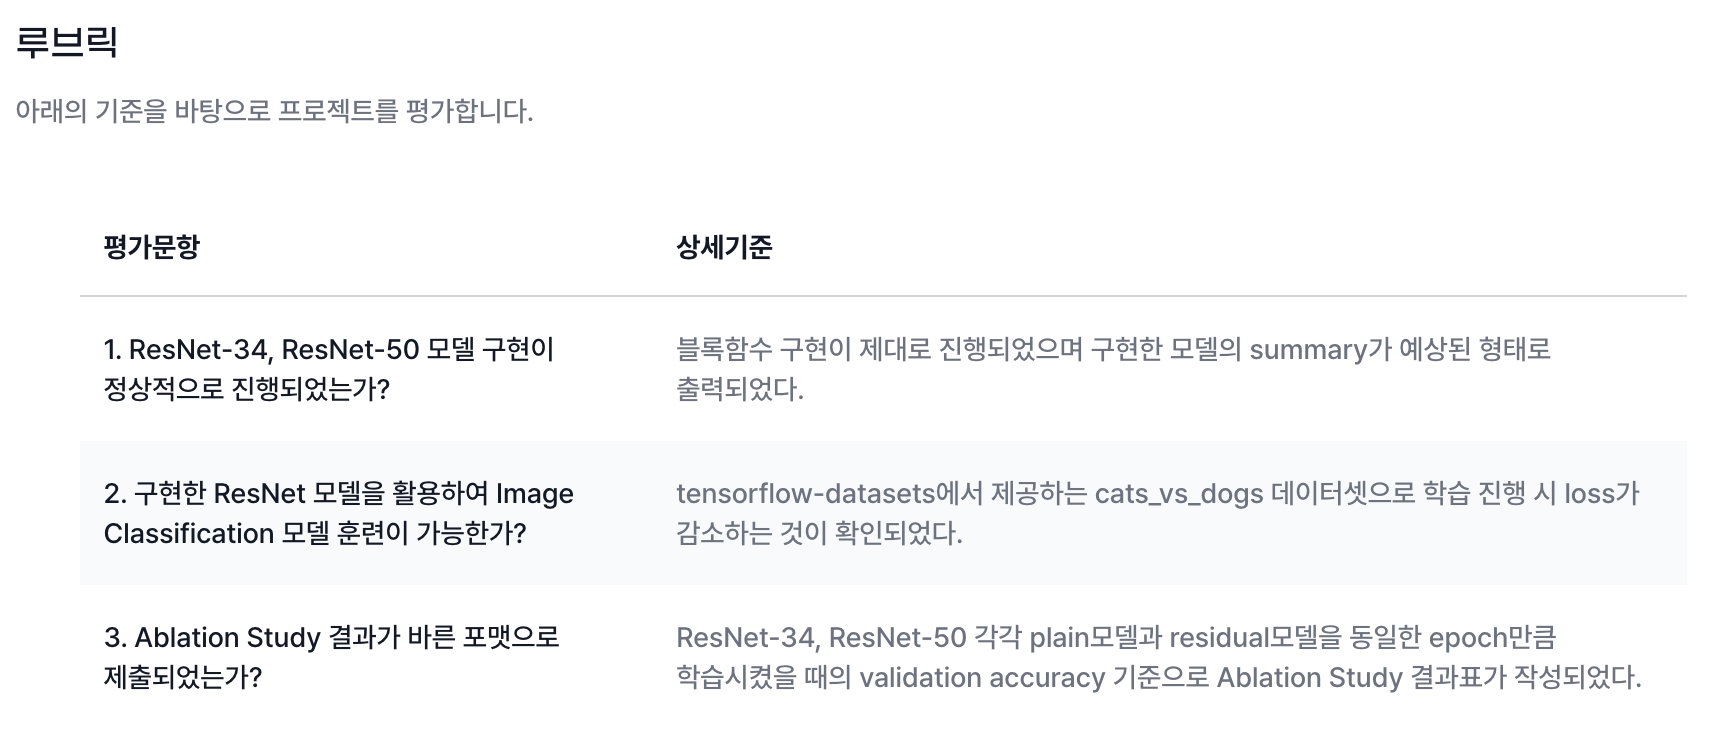

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
import os, shutil, pathlib

# dataset (kaggle / dogs-vs-cats)

텐서플로우 dataset api를 사용하면 로컬에서 오류가 계속 나는데,   
이는 이미지 파일에 손상이 있어서라고 판단된다.
따라서 캐글의 데이터 셋을 다운받아 모델 결과를 확인해 보자!

In [ ]:
#train / val /test dataset split
#train에 이미 cat0~cat12499 fname있다. (dog도 마찬가지)

original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cat_vs_dog_dataset')

def make_dataset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        new_dir = new_base_dir / subset_name / category
        os.makedirs(new_dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname, dst = new_dir/fname)

In [ ]:
make_dataset('train', 0, 5000)
make_dataset('val', 5000, 7500)
make_dataset('test', 7500, 12499)

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory('cat_vs_dog_data/train',
                                            image_size = (224,224),
                                            batch_size = 32)

val_dataset = image_dataset_from_directory('cat_vs_dog_data/val',
                                            image_size = (224,224),
                                            batch_size = 32)

test_dataset = image_dataset_from_directory('cat_vs_dog_data/test',
                                            image_size = (224,224),
                                            batch_size = 32)

Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 9998 files belonging to 2 classes.


# model build for Resnet ablation

# resnet 모델 build

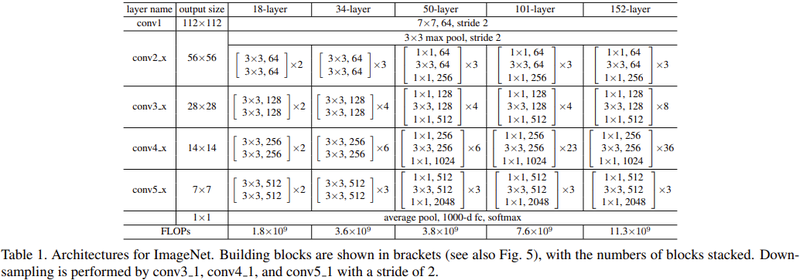

In [4]:
# resnet conv block
def conv_block(layer, channel, kernel_size, strides = 1, padding='same', activation='relu'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            padding=padding,
                            strides=strides)(layer)
    x = keras.layers.BatchNormalization()(x)
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [5]:
# resnet residual block
def residual_block(x ,#input_layer 
                   block_num=0, 
                   num_cnn=3, 
                   channel=64, 
                   is_50=True):
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            #블록마다 첫 블록의 shortcut은 conv_block을 지난다.
            if i==0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x
    

In [6]:
# conv_block(layer, channel, kernel_size, padding='same', activation='relu')
# residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True)

# resnet 모델 생성하는 함수

def build_resnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=1):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    conv1 = conv_block(input_layer, 64, (7,7), strides=2)
    res = keras.layers.MaxPool2D(pool_size=(3,3), strides=2)(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = residual_block(res, block_num, cnn, channel, is_50)
        
    output = keras.layers.GlobalAveragePooling2D()(res)
    
    output = keras.layers.Dense(num_classes, activation='sigmoid',kernel_initializer='he_normal')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model


In [7]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         )

resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3),
                         )

In [8]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

# plain(비교) model build

In [10]:
def plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
                
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

def build_plainnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=1):
    
    assert len(num_cnn_list) == len(channel_list)
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    conv1 = conv_block(input_layer, 64, (7,7), strides=2)
    plain = keras.layers.MaxPool2D(pool_size=(3,3), strides=2)(conv1)
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = plain_block(plain, block_num, cnn, channel, is_50)
        
    output = keras.layers.GlobalAveragePooling2D()(plain)
    
    output = keras.layers.Dense(num_classes, activation='sigmoid',kernel_initializer='he_normal')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [11]:
plain_34 = build_plainnet(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       )

plain_50 = build_plainnet(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3),
                       )

# model train

In [12]:
# model_1: resnet34

resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),)

In [15]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
313/313 [==============================] - 74s 214ms/step - loss: 0.7066 - accuracy: 0.6076 - val_loss: 0.9438 - val_accuracy: 0.5430
Epoch 2/10
313/313 [==============================] - 66s 209ms/step - loss: 0.5690 - accuracy: 0.7105 - val_loss: 0.9372 - val_accuracy: 0.5846
Epoch 3/10
313/313 [==============================] - 65s 209ms/step - loss: 0.4933 - accuracy: 0.7684 - val_loss: 0.7510 - val_accuracy: 0.6454
Epoch 4/10
313/313 [==============================] - 65s 209ms/step - loss: 0.4326 - accuracy: 0.8049 - val_loss: 1.0986 - val_accuracy: 0.5818
Epoch 5/10
313/313 [==============================] - 66s 209ms/step - loss: 0.3704 - accuracy: 0.8403 - val_loss: 0.5123 - val_accuracy: 0.7346
Epoch 6/10
313/313 [==============================] - 66s 209ms/step - loss: 0.3124 - accuracy: 0.8689 - val_loss: 0.6158 - val_accuracy: 0.7070
Epoch 7/10
313/313 [==============================] - 66s 209ms/step - loss: 0.2638 - accuracy: 0.8916 - val_loss: 0.6660 - val_ac

In [16]:
# model_2: resnet 50

In [17]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

history_50 = resnet_50.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
313/313 [==============================] - 52s 148ms/step - loss: 0.7513 - accuracy: 0.6169 - val_loss: 1.1564 - val_accuracy: 0.6418
Epoch 2/10
313/313 [==============================] - 44s 140ms/step - loss: 0.6411 - accuracy: 0.6526 - val_loss: 0.9151 - val_accuracy: 0.6022
Epoch 3/10
313/313 [==============================] - 43s 138ms/step - loss: 0.5630 - accuracy: 0.7150 - val_loss: 0.7073 - val_accuracy: 0.6514
Epoch 4/10
313/313 [==============================] - 43s 138ms/step - loss: 0.4929 - accuracy: 0.7644 - val_loss: 0.6015 - val_accuracy: 0.7180
Epoch 5/10
313/313 [==============================] - 43s 138ms/step - loss: 0.4527 - accuracy: 0.7922 - val_loss: 0.8681 - val_accuracy: 0.6238
Epoch 6/10
313/313 [==============================] - 43s 138ms/step - loss: 0.3914 - accuracy: 0.8267 - val_loss: 1.7175 - val_accuracy: 0.5794
Epoch 7/10
313/313 [==============================] - 43s 138ms/step - loss: 0.3266 - accuracy: 0.8603 - val_loss: 0.9699 - val_ac

In [18]:
# model_3: plain 34

In [20]:
plain_34 = build_plainnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3))

plain_34.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_p34 = plain_34.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
313/313 [==============================] - 65s 198ms/step - loss: 0.7093 - accuracy: 0.5219 - val_loss: 1.0899 - val_accuracy: 0.5428
Epoch 2/10
313/313 [==============================] - 61s 196ms/step - loss: 0.6953 - accuracy: 0.5094 - val_loss: 0.6927 - val_accuracy: 0.5400
Epoch 3/10
313/313 [==============================] - 61s 195ms/step - loss: 0.6790 - accuracy: 0.5746 - val_loss: 0.7244 - val_accuracy: 0.5006
Epoch 4/10
313/313 [==============================] - 61s 195ms/step - loss: 0.6675 - accuracy: 0.5959 - val_loss: 0.6859 - val_accuracy: 0.5792
Epoch 5/10
313/313 [==============================] - 61s 195ms/step - loss: 0.6824 - accuracy: 0.5592 - val_loss: 2.1827 - val_accuracy: 0.5428
Epoch 6/10
313/313 [==============================] - 61s 195ms/step - loss: 0.6831 - accuracy: 0.5562 - val_loss: 0.6770 - val_accuracy: 0.5790
Epoch 7/10
313/313 [==============================] - 61s 195ms/step - loss: 0.6719 - accuracy: 0.5890 - val_loss: 0.7625 - val_ac

In [21]:
# model_4: plain 50

In [22]:
plain_50 = build_plainnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))

plain_50.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

history_p50 = plain_50.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
313/313 [==============================] - 104s 316ms/step - loss: 0.6935 - accuracy: 0.5816 - val_loss: 0.7997 - val_accuracy: 0.5550
Epoch 2/10
313/313 [==============================] - 97s 308ms/step - loss: 0.6642 - accuracy: 0.6081 - val_loss: 1.1471 - val_accuracy: 0.6306
Epoch 3/10
313/313 [==============================] - 98s 313ms/step - loss: 0.6591 - accuracy: 0.6171 - val_loss: 1.9797 - val_accuracy: 0.5908
Epoch 4/10
313/313 [==============================] - 97s 308ms/step - loss: 0.6484 - accuracy: 0.6291 - val_loss: 0.8641 - val_accuracy: 0.5754
Epoch 5/10
313/313 [==============================] - 96s 307ms/step - loss: 0.6423 - accuracy: 0.6356 - val_loss: 0.6509 - val_accuracy: 0.6330
Epoch 6/10
313/313 [==============================] - 97s 308ms/step - loss: 0.6362 - accuracy: 0.6428 - val_loss: 1.6537 - val_accuracy: 0.5274
Epoch 7/10
313/313 [==============================] - 97s 309ms/step - loss: 0.6305 - accuracy: 0.6500 - val_loss: 1.0530 - val_a

# 모델 결과 시각화 

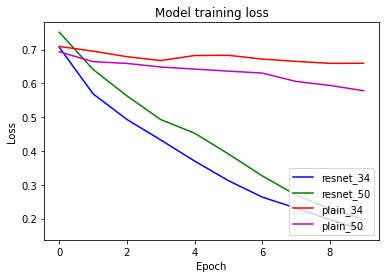

In [24]:
plt.plot(history_34.history['loss'], 'b')
plt.plot(history_50.history['loss'], 'g')
plt.plot(history_p34.history['loss'], 'r')
plt.plot(history_p50.history['loss'], 'm')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

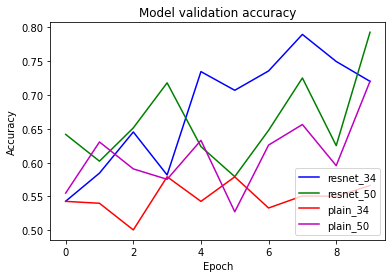

In [25]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_p34.history['val_accuracy'], 'r')
plt.plot(history_p50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

# 회고

1. url로 tfds로 데이터를 load하는 방법과 로컬에 데이터를 다운받아 image_dataset_from_directory를 사용하는 것에 차이가 있다.  
   -> 첫번쨰 방법은 코랩에서 되지만 lms 커널 상에서 안된다..  
   
   
2. 각 모델이 몇 epoch에서 과대적합이 발생하는 지 파악하고, 그 때의 모델을 모니터링하는 것이 필요할 것 같다.   
   따라서 epoch를 늘려서 학습시켜 봐야한다.  
   
     
3. validation accuracy의 값이 튀는 경향이 있어보이는데, 에포크를 늘리면 어느정도 해결될 것 같다.  
  
  
4. validation accuracy 기준으로 성능이 좋은 모델은 resnet34 > resnet50 > plain50 > plain34 순 이다.